In [2]:
# This script analyses the velocity data for Au/MNL b = 2 scattering:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
import glob
import shutil
import re

import matplotlib.colors as mcolors

from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks


In [3]:
# Definitions:
def read_file(filename, skiplines):
    with open(filename) as file:
        lines = file.readlines()
        total_lines = len(lines)
#         print('Total lines:', total_lines)

    # Read the data:
    rlines = lines[skiplines:]
    # Extract data from file
    data = np.array([list(map(float, line.strip().split())) for line in rlines])
#     print("Shape of data:", data.shape)
    header = lines[skiplines-1].strip().split()
    dt = data[1][0] - data[0][0]; # Time interval between data
    return header, dt, data

def VDOS(time, VACF, moving_avg, peak_percentage):
    """
    VACF = 1D Velocity autocorrelation function data
    time = time data in ps
    moving_avg = Moving average value
    peak_percentage = While looking for peaks this % of maximum peak height is considered as peak.
    """
    time_step = time[1] - time[0]
    
    # Compute the FFT.
    fft_result = np.fft.fft(VACF)

    # Compute the power spectrum.
    power_spectrum = np.abs(fft_result)**2

    # Compute the corresponding frequencies for each FFT bin.
    frequencies = np.fft.fftfreq(len(VACF), time_step)

    # Plot the power spectrum vs frequency.
    mask = frequencies >= 0  # only consider the positive frequencies

    freq_new = frequencies[mask]
    power_spectrum = power_spectrum[mask]
    normalizer1 = np.max(power_spectrum)

    # computing the peak magnitude and peak position:
    peak_threshold = np.max(power_spectrum) * peak_percentage/100  # for example, half of the maximum value
    peaks, _ = find_peaks(power_spectrum, height=peak_threshold)
    peak_freq = frequencies[peaks]
    peak_freq_mag = power_spectrum[peaks]    #/np.max(power_spectrum)
    
    return normalizer1, freq_new, power_spectrum, peak_freq, peak_freq_mag

def non_zero_col(df, ref_col):
    """
    df = name of the dataframe
    ref_col = reference used to select non-zero data
    """
    new_df = df.loc[df.iloc[:, ref_col] !=0]
    return new_df

def normalize(arr, Eq_time):
    """For a given array of time VACFx, y, z, and total
    this function normalizes the VACF data
    Useful for Au and Tilted polyethylene """
    
    Header  = ['Timestep', 'Time', 'Z_l', 'LVx', 'LVy', 'LVz', 'Z_r', 'RVx', 'RVy', 'RVz']
    pd_data = pd.DataFrame(arr, columns =Header)
    pd_data['Time'] = pd_data['Time'] - Eq_time
    return pd_data

# Velocity data
Reading the data

In [ ]:
# Loading the velocity data:
with open('./Extracted_Vel_data/Vel_data_info1.dat') as file:
    lines = file.readlines()
    header = lines[0].strip().split()
    print(header)
    k_num_jid = np.array([list(map(float, line.strip().split())) for line in lines[1:]])

k_arr = k_num_jid[:, 0].astype(int)    # K number
freq_arr = k_num_jid[:, 1]             # LA frequency
jid = k_num_jid[:, 2].astype(int)      # jobid
vel_time_arr = k_num_jid[:, 3].astype(int)  # Time in ps where velocity tracking begins

In [ ]:
plt.rcParams.update({'font.serif':'Arial', 'font.size': 14.0, 
                     'xtick.labelsize': 13, 'ytick.labelsize': 13,
                    'legend.fontsize':12,
                    'figure.dpi': 80.0, 'figure.figsize': [9, 5]})

# np.set_printoptions(formatter={'all': '{:.2e}'.format})   # Sets print option for all

Md_dt = 0.00025              # timestep ps
d_steps = 10                 # steps between data

peak = 5                     # 1 means 1%         

# Making the folder:
dir_path = f'./Extracted_VACF_data/{peak}%_peak'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
# Reading the data:
for i in np.arange(len(jid)):

    print('K_num',k_arr[i], 'Freq:', freq_arr[i], 'Jobid:', jid[i])
    datafile = f'./Extracted_Vel_data/Vel_{k_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}.dat'
    
    # Read the velocity data:
    ## header = header of data, dt = time interval of data
    header, dt,  globals()[f'Vel_k_num_{k_arr[i]}'] = read_file(datafile, 2)
        
    #print(header[1:])
    # Normalize AuL VACF data by VACF total
    globals()[f'Vel_k_num_{k_arr[i]}'] = normalize(globals()[f'Vel_k_num_{k_arr[i]}'], vel_time_arr[i]-125)
    
    # Plotting the Velocities and power spectrum:
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    plt.subplots_adjust(hspace = 0.38, wspace = 0.48)
    
    #Velocity left side:
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVx'], 'g-', linewidth = 0.8, markersize = 0.2, label='$V_{Reflected}^{x}$')
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVy'], 'b-', linewidth = 0.8,markersize = 0.2, label='$V_{Reflected}^{y}$')
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVz'], 'r-', linewidth = 0.8, markersize = 0.2, label='$V_{Reflected}^{z}$')
    axs[0, 0].set_xlabel(f'Time (ps)')
    axs[0, 0].set_ylabel(f'Velocity ($\u00C5.ps^-$$^1$)')
    axs[0, 0].set_xlim(125, 325)
    axs[0, 0].set_ylim(-0.055, 0.055)
#     axs[0, 0].set_title(f'Input: f={freq_arr[i]} THz, \nReflected wave in left Au lead')
#     axs[0, 0].legend()
    axs[0, 0].legend(loc='upper right', frameon = False)
    
    #Velocity Right side:
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVx'], 'g', linewidth = 0.8,markersize = 0.2, label='$V_{Transmitted}^{x}$')
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVy'], 'b', linewidth = 0.8,markersize = 0.2, label='$V_{Transmitted}^{y}$')
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVz'], 'r', linewidth = 0.8,markersize = 0.2,label='$V_{Transmitted}^{z}$')
    axs[0, 1].set_xlabel(f'Time (ps)')
    axs[0, 1].set_ylabel(f'Velocity ($\u00C5.ps^-$$^1$)')
    axs[0, 1].set_xlim(125, 325)
    axs[0, 1].set_ylim(-0.028, 0.028)
#     axs[0, 1].set_title('Transmitted wave in right Au lead')
#     axs[0, 1].legend()
    axs[0, 1].legend(frameon = False, loc='upper left')
    
    # Power spectrum of reflected left side:
    # normx = maximum value in power spectrum
    # L_freqz = positive frequencies, L_vdosx = Power spectrum, fx = frequencies with peaks, mx = magnitude of fx
    Lnormx, L_freqx, L_vdosx, Lfx, Lmx = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVx'], 1, peak)
    Lnormy, L_freqy, L_vdosy, Lfy, Lmy = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVy'], 1, peak)
    Lnormz, L_freqz, L_vdosz, Lfz, Lmz = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVz'], 1, peak)
    
    L_freq = [Lfx, Lfy, Lfz]
    
    mL = np.max([Lnormx, Lnormy, Lnormz])
    
    axs[1, 0].plot(L_freqx, L_vdosx, 'g',linewidth = 1.5, label='$X_{Reflected}$')
    axs[1, 0].plot(L_freqy, L_vdosy, 'b',linewidth = 1.5, label='$Y_{Reflected}$')
    axs[1, 0].plot(L_freqz, L_vdosz, 'r',linewidth = 1.5, label='$Z_{Reflected}$')
    axs[1, 0].set_xlabel(f'Frequency, $\\nu$ (THz)')
    axs[1, 0].set_ylabel(f'Power spectrum, F($\\nu$) (a.u)')
    axs[1, 0].set_xlim(0, 3)
    axs[1, 0].legend(frameon=False)
    
    # Power spectrum on Transmitted right side:
    Rnormx, R_freqx, R_vdosx, Rfx, Rmx = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVx'], 1, peak)
    Rnormy, R_freqy, R_vdosy, Rfy, Rmy = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVy'], 1, peak)
    Rnormz, R_freqz, R_vdosz, Rfz, Rmz = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVz'], 1, peak)
    
    R_freq = [Rfx, Rfy, Rfz]
    
    mR = np.max([Rnormx, Rnormy, Rnormz])
    
    axs[1, 1].plot(R_freqx, R_vdosx, 'g', linewidth = 1.5, label='$X_{Transmitted}$')
    axs[1, 1].plot(R_freqy, R_vdosy, 'b', linewidth = 1.5, label='$Y_{Transmitted}$')
    axs[1, 1].plot(R_freqz, R_vdosz, 'r', linewidth = 1.5, label='$Z_{Transmitted}$')
    axs[1, 1].set_xlabel(f'Frequency, $\\nu$ (THz)')
    axs[1, 1].set_ylabel(f'Power spectrum, F($\\nu$) (a.u)')
    axs[1, 1].set_xlim(0, 3)
    axs[1, 1].legend(frameon=False)
    
#     plt.tight_layout()
#     plt.savefig(f'./Extracted_Vel_data/{peak}%_peak/Vel_plot_{k_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}_v2.png', dpi= 1200, bbox_inches = 'tight', facecolor="w")
    plt.show()


# Analysing the data for straight chain

In [ ]:
# Loading the velocity data:
with open('./Extracted_Vel_data/Vel_data_info2.dat') as file:
    lines = file.readlines()
    header = lines[0].strip().split()
    print(header)
    k_num_jid = np.array([list(map(float, line.strip().split())) for line in lines[1:]])

k_arr = k_num_jid[:, 0].astype(int)    # K number
freq_arr = k_num_jid[:, 1]             # LA frequency
jid = k_num_jid[:, 2].astype(int)      # jobid
vel_time_arr = k_num_jid[:, 3].astype(int)  # Time in ps where velocity tracking begins

In [ ]:
plt.rcParams.update({'font.serif':'Arial', 'font.size': 14.0, 
                     'xtick.labelsize': 13, 'ytick.labelsize': 13,
                    'legend.fontsize':12,
                    'figure.dpi': 80.0, 'figure.figsize': [9, 5]})

# np.set_printoptions(formatter={'all': '{:.2e}'.format})   # Sets print option for all

Md_dt = 0.00025              # timestep ps
d_steps = 10                 # steps between data

peak = 5                     # 1 means 1%         

# Making the folder:
dir_path = f'./Extracted_VACF_data/{peak}%_peak'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
# Reading the data:
for i in np.arange(len(jid)):

    print('K_num',k_arr[i], 'Freq:', freq_arr[i], 'Jobid:', jid[i])
    datafile = f'./Extracted_Vel_data/Vel_{k_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}.dat'
    
    # Read the velocity data:
    ## header = header of data, dt = time interval of data
    header, dt,  globals()[f'Vel_k_num_{k_arr[i]}'] = read_file(datafile, 2)
        
    #print(header[1:])
    # Normalize AuL VACF data by VACF total
    globals()[f'Vel_k_num_{k_arr[i]}'] = normalize(globals()[f'Vel_k_num_{k_arr[i]}'], vel_time_arr[i])
    
    # Plotting the Velocities and power spectrum:
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    plt.subplots_adjust(hspace = 0.38, wspace = 0.48)
    
    #Velocity left side:
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVx'], 'g-', linewidth = 0.8, markersize = 0.2, label='$V_{Reflected}^{x}$')
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVy'], 'b-', linewidth = 0.8,markersize = 0.2, label='$V_{Reflected}^{y}$')
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVz'], 'r-', linewidth = 0.8, markersize = 0.2, label='$V_{Reflected}^{z}$')
    axs[0, 0].set_xlabel(f'Time (ps)')
    axs[0, 0].set_ylabel(f'Velocity ($\u00C5.ps^-$$^1$)')
    axs[0, 0].set_xlim(100, 200)
#     axs[0, 0].set_ylim(-0.055, 0.055)
#     axs[0, 0].set_title(f'Input: f={freq_arr[i]} THz, \nReflected wave in left Au lead')
#     axs[0, 0].legend()
    axs[0, 0].legend(loc='upper right', frameon = False)
    
    #Velocity Right side:
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVx'], 'g', linewidth = 0.8,markersize = 0.2, label='$V_{Transmitted}^{x}$')
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVy'], 'b', linewidth = 0.8,markersize = 0.2, label='$V_{Transmitted}^{y}$')
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVz'], 'r', linewidth = 0.8,markersize = 0.2,label='$V_{Transmitted}^{z}$')
    axs[0, 1].set_xlabel(f'Time (ps)')
    axs[0, 1].set_ylabel(f'Velocity ($\u00C5.ps^-$$^1$)')
    axs[0, 1].set_xlim(100, 200)
#     axs[0, 1].set_ylim(-0.028, 0.028)
#     axs[0, 1].set_title('Transmitted wave in right Au lead')
#     axs[0, 1].legend()
    axs[0, 1].legend(frameon = False, loc='upper left')
    
    # Power spectrum of reflected left side:
    # normx = maximum value in power spectrum
    # L_freqz = positive frequencies, L_vdosx = Power spectrum, fx = frequencies with peaks, mx = magnitude of fx
    Lnormx, L_freqx, L_vdosx, Lfx, Lmx = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVx'], 1, peak)
    Lnormy, L_freqy, L_vdosy, Lfy, Lmy = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVy'], 1, peak)
    Lnormz, L_freqz, L_vdosz, Lfz, Lmz = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVz'], 1, peak)
    
    L_freq = [Lfx, Lfy, Lfz]
    
    mL = np.max([Lnormx, Lnormy, Lnormz])
    
    axs[1, 0].plot(L_freqx, L_vdosx, 'g',linewidth = 1.5, label='$X_{Reflected}$')
    axs[1, 0].plot(L_freqy, L_vdosy, 'b',linewidth = 1.5, label='$Y_{Reflected}$')
    axs[1, 0].plot(L_freqz, L_vdosz, 'r',linewidth = 1.5, label='$Z_{Reflected}$')
    axs[1, 0].set_xlabel(f'Frequency, $\\nu$ (THz)')
    axs[1, 0].set_ylabel(f'Power spectrum, F($\\nu$) (a.u)')
    axs[1, 0].set_xlim(0, 3)
    axs[1, 0].legend(frameon=False)
    
    # Power spectrum on Transmitted right side:
    Rnormx, R_freqx, R_vdosx, Rfx, Rmx = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVx'], 1, peak)
    Rnormy, R_freqy, R_vdosy, Rfy, Rmy = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVy'], 1, peak)
    Rnormz, R_freqz, R_vdosz, Rfz, Rmz = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVz'], 1, peak)
    
    R_freq = [Rfx, Rfy, Rfz]
    
    mR = np.max([Rnormx, Rnormy, Rnormz])
    
    axs[1, 1].plot(R_freqx, R_vdosx, 'g', linewidth = 1.5, label='$X_{Transmitted}$')
    axs[1, 1].plot(R_freqy, R_vdosy, 'b', linewidth = 1.5, label='$Y_{Transmitted}$')
    axs[1, 1].plot(R_freqz, R_vdosz, 'r', linewidth = 1.5, label='$Z_{Transmitted}$')
    axs[1, 1].set_xlabel(f'Frequency, $\\nu$ (THz)')
    axs[1, 1].set_ylabel(f'Power spectrum, F($\\nu$) (a.u)')
    axs[1, 1].set_xlim(0, 3)
    axs[1, 1].legend(frameon=False)
    
#     plt.tight_layout()
#     plt.savefig(f'./Extracted_Vel_data/{peak}%_peak/Vel_plot_{k_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}_v3.png', dpi= 1200, bbox_inches = 'tight', facecolor="w")
    plt.show()


In [ ]:
# Plotting the Energy on left side, right side, and the interface:
# GLOBAL CONTROL FOR THE PLOTS


# print(plt.rcParams)
k_num_val = [83, 167, 176, 248]

for i in k_num_val:
    plt.subplots(figsize=(5,3))
    # Addressing reviewers comment:
    plt.plot(globals()[f'avg_k_{i}']['Time(ps)'], globals()[f'avg_k_{i}']['Au_left_energy'], linewidth = .8, label="$E_{left}$")
    plt.plot(globals()[f'avg_k_{i}']['Time(ps)'], globals()[f'avg_k_{i}']['Au_right_energy'], linewidth = .8,label="$E_{right}$")
    plt.plot(globals()[f'avg_k_{i}']['Time(ps)'], globals()[f'avg_k_{i}']['Au_MNL_energy'], linewidth = .8, label="$E_{Au/MNL}$")
    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (eV)')
    plt.legend(loc='center left', frameon=False)
    plt.savefig(f'./ETC_ERC_data/Au_MNL_b-2/Reviewer_comment_1.9/Energy_plot_k_val-{i}.png'
                , dpi=300, bbox_inches = 'tight', facecolor="w")
    plt.show()

# Processing the 6.14 and 6.19 THz data separately

In [ ]:
plt.legend?

In [ ]:
# np.set_printoptions(formatter={'all': '{:.2e}'.format})   # Sets print option for all

Md_dt = 0.00025              # timestep ps
d_steps = 10                 # steps between data

peak = 5                     # 1 means 1%         

# Making the folder:
dir_path = f'./Extracted_VACF_data/{peak}%_peak'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
# Reading the data:
for i in [10, 11]:

    print('K_num',k_arr[i], 'Freq:', freq_arr[i], 'Jobid:', jid[i])
    datafile = f'./Extracted_Vel_data/Vel_{k_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}.dat'
    
    # Read the velocity data:
    ## header = header of data, dt = time interval of data
    header, dt,  globals()[f'Vel_k_num_{k_arr[i]}'] = read_file(datafile, 2)
        
    #print(header[1:])
    # Normalize AuL VACF data by VACF total
    globals()[f'Vel_k_num_{k_arr[i]}'] = normalize(globals()[f'Vel_k_num_{k_arr[i]}'], vel_time_arr[i])
    
    globals()[f'Vell_k_num_{k_arr[i]}'] = globals()[f'Vel_k_num_{k_arr[i]}'].iloc[::6, :].reset_index(drop=True)
    print(globals()[f'Vell_k_num_{k_arr[i]}'].shape)
    
    # Plotting the Velocities and power spectrum:
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.35)
    
    #Velocity left side:
    axs[0, 0].plot(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['LVx'], 'o', markersize = 0.3, label='Vx')
    axs[0, 0].plot(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['LVy'], 'o', markersize = 0.3, label='Vy')
    axs[0, 0].plot(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['LVz'], 'o', markersize = 0.3, label='Vz')
    axs[0, 0].set_xlabel(f'Time [ps]')
    axs[0, 0].set_ylabel(f'Velocity [A/ps]')
    axs[0, 0].set_title(f'Input: f={freq_arr[i]} THz, \nReflected wave in left Au lead')
    axs[0, 0].legend()
    #axs[0, 0].legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
    
    #Velocity Right side:
    axs[0, 1].plot(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['RVx'], 'o', markersize = 0.3, label='Vx')
    axs[0, 1].plot(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['RVy'], 'o', markersize = 0.3, label='Vy')
    axs[0, 1].plot(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['RVz'], 'o', markersize = 0.3,label='Vz')
    axs[0, 1].set_xlabel(f'Time [ps]')
    axs[0, 1].set_ylabel(f'Velocity [A/ps]')
    axs[0, 1].set_title('Transmitted wave in right Au lead')
    axs[0, 1].legend()
    #axs[0, 1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
    
    # Power spectrum of reflected left side:
    # normx = maximum value in power spectrum
    # L_freqz = positive frequencies, L_vdosx = Power spectrum, fx = frequencies with peaks, mx = magnitude of fx
    Lnormx, L_freqx, L_vdosx, Lfx, Lmx = VDOS(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['LVx'], 1, peak)
    Lnormy, L_freqy, L_vdosy, Lfy, Lmy = VDOS(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['LVy'], 1, peak)
    Lnormz, L_freqz, L_vdosz, Lfz, Lmz = VDOS(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['LVz'], 1, peak)
    
    L_freq = [Lfx, Lfy, Lfz]
    
    mL = np.max([Lnormx, Lnormy, Lnormz])
    
    axs[1, 0].plot(L_freqx, L_vdosx, label='X-dirn')
    axs[1, 0].plot(L_freqy, L_vdosy, label='Y-dirn')
    axs[1, 0].plot(L_freqz, L_vdosz, label='Z-dirn')
    axs[1, 0].set_xlabel(f'Frequency [THz]')
    axs[1, 0].set_ylabel(f'Power spectrum [a.u]')
    axs[1, 0].set_xlim(0, 7)
    axs[1, 0].legend()
    
    # Power spectrum on Transmitted right side:
    Rnormx, R_freqx, R_vdosx, Rfx, Rmx = VDOS(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['RVx'], 1, peak)
    Rnormy, R_freqy, R_vdosy, Rfy, Rmy = VDOS(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['RVy'], 1, peak)
    Rnormz, R_freqz, R_vdosz, Rfz, Rmz = VDOS(globals()[f'Vell_k_num_{k_arr[i]}']['Time'], globals()[f'Vell_k_num_{k_arr[i]}']['RVz'], 1, peak)
    
    R_freq = [Rfx, Rfy, Rfz]
    
    mR = np.max([Rnormx, Rnormy, Rnormz])
    
    axs[1, 1].plot(R_freqx, R_vdosx, label='X-dirn')
    axs[1, 1].plot(R_freqy, R_vdosy, label='Y-dirn')
    axs[1, 1].plot(R_freqz, R_vdosz, label='Z-dirn')
    axs[1, 1].set_xlabel(f'Frequency [THz]')
    axs[1, 1].set_ylabel(f'Power spectrum [a.u]')
    axs[1, 1].set_xlim(0, 7)
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig(f'./Extracted_Vel_data/{peak}%_peak/Vel_plot_{k_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}.png', dpi= 300, bbox_inches = 'tight', facecolor="w")
    plt.show()


# Addressing Comment 1.7: Anharmonicity: 
The question of anharmonicity in the wave packet simulations would be easily answered by computing amplitude dependence. 
Generally, these kinds of simulations are done for very low amplitudes to eliminate anharmonicity. But the questions above 
could be answered by showing that the additional peaks at different frequencies decrease/disappear as the amplitude is 
decreased.

Frequency Choosen: 3.48, K_num: 193

In [ ]:
# Loading the velocity data:
vel_time_arr = [0]*4  # Time in ps where velocity tracking begins

k_arr = [193]*4
freq_arr = [3.48]*4
jid = [1468227, 1468229, 1468232, 1468233]

def normalize(arr, Eq_time):
    """For a given array of time VACFx, y, z, and total
    this function normalizes the VACF data
    Useful for Au and Tilted polyethylene """
    
    Header  = ['Timestep', 'Time', 'Z_l1', 'LVx1', 'LVy1', 'LVz1', 'Z_l2', 'LVx2', 'LVy2', 'LVz2', 
               'Z_r', 'RVx', 'RVy', 'RVz']
    
    pd_data = pd.DataFrame(arr, columns =Header)
    pd_data['Time'] = pd_data['Time'] - Eq_time
    return pd_data

# np.set_printoptions(formatter={'all': '{:.2e}'.format})   # Sets print option for all

Md_dt = 0.00025              # timestep ps
d_steps = 10                 # steps between data

peak = 5                     # 1 means 1%         

# Making the folder:
dir_path = f'./Amplitude_variation_k_193/Extracted_Vel_data/{peak}%_peak'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
# Reading the data:
for i in np.arange(len(jid)):

    print('K_num',k_arr[i], 'Freq:', freq_arr[i], 'Jobid:', jid[i])
    datafile = f'./Amplitude_variation_k_193/Extracted_Vel_data/Vel_{k_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}.dat'
    
    # Read the velocity data:
    ## header = header of data, dt = time interval of data
    header, dt,  globals()[f'Vel_k_num_{k_arr[i]}'] = read_file(datafile, 2)
        
    #print(header[1:])
    # Normalize AuL VACF data by VACF total
    globals()[f'Vel_k_num_{k_arr[i]}'] = normalize(globals()[f'Vel_k_num_{k_arr[i]}'], vel_time_arr[i])
    
    # Plotting the Velocities and power spectrum:
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.35)
    
    #Velocity left side:
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVx2'], 'o', markersize = 0.2, label='Vx')
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVy2'], 'o', markersize = 0.2, label='Vy')
    axs[0, 0].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVz2'], 'o', markersize = 0.2, label='Vz')
    axs[0, 0].set_xlabel(f'Time [ps]')
    axs[0, 0].set_ylabel(f'Velocity [A/ps]')
    axs[0, 0].set_title(f'Input: f={freq_arr[i]} THz, \nReflected wave in left Au lead')
    axs[0, 0].legend()
    #axs[0, 0].legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
    
    #Velocity Right side:
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVx'], 'o', markersize = 0.2, label='Vx')
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVy'], 'o', markersize = 0.2, label='Vy')
    axs[0, 1].plot(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVz'], 'o', markersize = 0.2,label='Vz')
    axs[0, 1].set_xlabel(f'Time [ps]')
    axs[0, 1].set_ylabel(f'Velocity [A/ps]')
    axs[0, 1].set_title('Transmitted wave in right Au lead')
    axs[0, 1].legend()
    #axs[0, 1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
    
    # Power spectrum of reflected left side:
    # normx = maximum value in power spectrum
    # L_freqz = positive frequencies, L_vdosx = Power spectrum, fx = frequencies with peaks, mx = magnitude of fx
    Lnormx, L_freqx, L_vdosx, Lfx, Lmx = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVx2'], 1, peak)
    Lnormy, L_freqy, L_vdosy, Lfy, Lmy = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVy2'], 1, peak)
    Lnormz, L_freqz, L_vdosz, Lfz, Lmz = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['LVz2'], 1, peak)
    
    L_freq = [Lfx, Lfy, Lfz]
    
    mL = np.max([Lnormx, Lnormy, Lnormz])
    
    axs[1, 0].plot(L_freqx, L_vdosx, label='X-dirn')
    axs[1, 0].plot(L_freqy, L_vdosy, label='Y-dirn')
    axs[1, 0].plot(L_freqz, L_vdosz, label='Z-dirn')
    axs[1, 0].set_xlabel(f'Frequency [THz]')
    axs[1, 0].set_ylabel(f'Power spectrum [a.u]')
    axs[1, 0].set_xlim(2, 8)
    axs[1, 0].legend()
    
    # Power spectrum on Transmitted right side:
    Rnormx, R_freqx, R_vdosx, Rfx, Rmx = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVx'], 1, peak)
    Rnormy, R_freqy, R_vdosy, Rfy, Rmy = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVy'], 1, peak)
    Rnormz, R_freqz, R_vdosz, Rfz, Rmz = VDOS(globals()[f'Vel_k_num_{k_arr[i]}']['Time'], globals()[f'Vel_k_num_{k_arr[i]}']['RVz'], 1, peak)
    
    R_freq = [Rfx, Rfy, Rfz]
    
    mR = np.max([Rnormx, Rnormy, Rnormz])
    
    axs[1, 1].plot(R_freqx, R_vdosx, label='X-dirn')
    axs[1, 1].plot(R_freqy, R_vdosy, label='Y-dirn')
    axs[1, 1].plot(R_freqz, R_vdosz, label='Z-dirn')
    axs[1, 1].set_xlabel(f'Frequency [THz]')
    axs[1, 1].set_ylabel(f'Power spectrum [a.u]')
    axs[1, 1].set_xlim(2, 8)
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig(f'./Amplitude_variation_k_193/Extracted_Vel_data/{peak}%_peak/Vel_plot_{k_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}.png', dpi= 300, bbox_inches = 'tight', facecolor="w")
    plt.show()


# Future work figure (mode conversion): Thesis

In [56]:
# straight chain:
velz_0 = './Phonon_mode_conversion_fig_future_work/Tilted_chain_584760/Frame_0_velz.txt'
velz_80 = './Phonon_mode_conversion_fig_future_work/Tilted_chain_584760/Frame_80_velz.txt'
velx_80 = './Phonon_mode_conversion_fig_future_work/Tilted_chain_584760/Frame_80_velx.txt'
vely_80 = './Phonon_mode_conversion_fig_future_work/Tilted_chain_584760/Frame_80_vely.txt'

tchain_ini = pd.read_csv(f'{velz_0}', skiprows=2, delimiter=" ", header=None, names=['pos', 'vel', 'NaN'])
tchain_z = pd.read_csv(f'{velz_80}', skiprows=2, delimiter=" ", header=None, names=['pos', 'vel', 'NaN'])
tchain_x = pd.read_csv(f'{velx_80}', skiprows=2, delimiter=" ", header=None, names=['pos', 'vel', 'NaN'])
tchain_y = pd.read_csv(f'{vely_80}', skiprows=2, delimiter=" ", header=None, names=['pos', 'vel', 'NaN'])

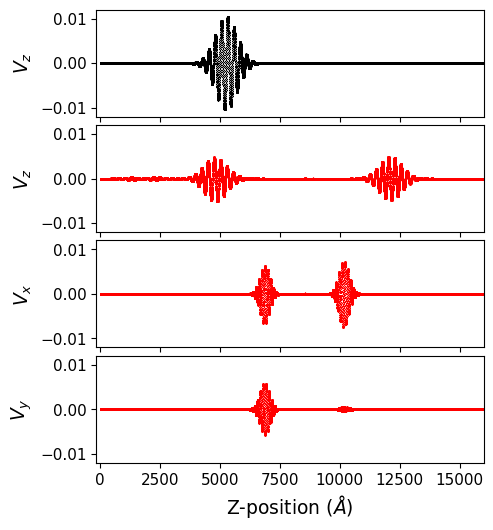

In [57]:
fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize = (5, 6))
plt.subplots_adjust(hspace=0.08)

axs[0].plot(tchain_ini['pos'], tchain_ini['vel'],'ko', markersize=0.05)
# axs[0].set_xlabel("Position (A)")
axs[0].set_ylabel("$V_z$")
axs[0].set_ylim(-.012, .012)
# axs[0].set_xticks()
# axs[0].set_xticks(visible=False)
axs[0].set_xlim(-150, 15999)

axs[1].plot(tchain_z['pos'], tchain_z['vel'],'ro', markersize=0.05)
# axs[0].set_xlabel("Position (A)")
axs[1].set_ylabel("$V_z$")
axs[1].set_ylim(-.012, .012)
axs[1].set_xlim(-150, 15999)

axs[2].plot(tchain_x['pos'], tchain_x['vel'],'ro', markersize=0.05)
axs[2].set_ylabel("$V_x$")
axs[2].set_ylim(-.012, .012)
axs[2].set_xlim(-150, 15999)

axs[3].plot(tchain_y['pos'], tchain_y['vel'],'ro', markersize=0.05)
axs[3].set_ylabel("$V_y$")
axs[3].set_ylim(-.012, .012)
axs[3].set_xlim(-150, 16000)
axs[3].set_xlabel("Z-position ($\AA$)")
plt.savefig(f'./Tilted_chain1.png', dpi= 300, bbox_inches = 'tight', facecolor="w")
plt.show()
plt.close()

In [51]:
# straight chain:
velz_0 = './Phonon_mode_conversion_fig_future_work/Straight_chain_1843739/Frame_0_velz.txt'
velz_40 = './Phonon_mode_conversion_fig_future_work/Straight_chain_1843739/Frame_40_velz.txt'
velx_40 = './Phonon_mode_conversion_fig_future_work/Straight_chain_1843739/Frame_40_velx.txt'
vely_40 = './Phonon_mode_conversion_fig_future_work/Straight_chain_1843739/Frame_40_vely.txt'

schain_ini = pd.read_csv(f'{velz_0}', skiprows=2, delimiter=" ", header=None, names=['pos', 'vel', 'NaN'])
schain_z = pd.read_csv(f'{velz_40}', skiprows=2, delimiter=" ", header=None, names=['pos', 'vel', 'NaN'])
schain_x = pd.read_csv(f'{velx_40}', skiprows=2, delimiter=" ", header=None, names=['pos', 'vel', 'NaN'])
schain_y = pd.read_csv(f'{vely_40}', skiprows=2, delimiter=" ", header=None, names=['pos', 'vel', 'NaN'])

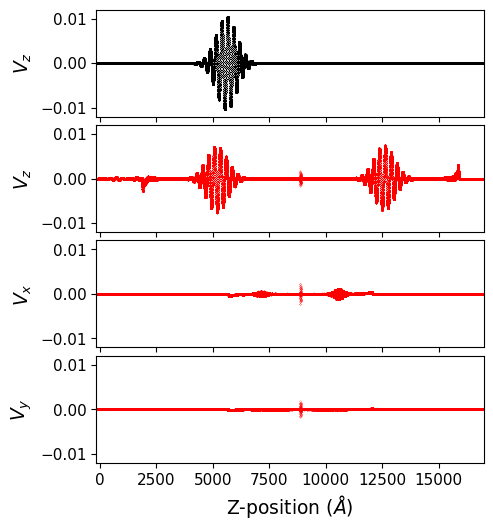

In [55]:
fig, axss = plt.subplots(nrows = 4, ncols = 1, figsize = (5, 6))
plt.subplots_adjust(hspace=0.08)

axss[0].plot(schain_ini['pos'], schain_ini['vel'],'ko', markersize=0.05)
# axs[0].set_xlabel("Position (A)")
axss[0].set_ylabel("$V_z$")
axss[0].set_ylim(-.012, .012)
# axs[0].set_xticks()
# axs[0].set_xticks(visible=False)
axss[0].set_xlim(-150, 16999)

axss[1].plot(schain_z['pos'], schain_z['vel'],'or', markersize=0.05)
# axs[0].set_xlabel("Position (A)")
axss[1].set_ylabel("$V_z$")
axss[1].set_ylim(-.012, .012)
axss[1].set_xlim(-150, 16999)

axss[2].plot(schain_x['pos'], schain_x['vel'],'or', markersize=0.05)
axss[2].set_ylabel("$V_x$")
axss[2].set_ylim(-.012, .012)
axss[2].set_xlim(-150, 16999)

axss[3].plot(schain_y['pos'], schain_y['vel'],'or', markersize=0.05)
axss[3].set_ylabel("$V_y$")
axss[3].set_ylim(-.012, .012)
axss[3].set_xlim(-150, 17000)
axss[3].set_xlabel("Z-position ($\AA$)")
plt.savefig(f'./Straight_chain1.png', dpi= 300, bbox_inches = 'tight', facecolor="w")
plt.show()